In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import igraph as ig

# Part 1: Initialisation

User draws a rectangle around the object in the image that they wish to segment out.

The code below will open a new window. The mouse is used to draw a rectangle. This rectangle is used to generate the trimaps

## Trimaps

Trimap contains pixel values ranging from 0-2. Where:
  - 0 = background
  - 1 = foreground
  - 1 = unknown/border
  
User provides $T_B$ (trimap background). $T_U$ is set to $\bar{T_B}$, the complement of the background.

We also keep track of a value $\alpha$ for each pixel. The $\alpha$ values indicate whether each pixel is in the foreground or background. $\alpha_n: $
  - 0 = background
  - 1 = foreground

For the pixels in $T_U$, these $\alpha$ values are refined. For the rest they remain fixed. 

In [2]:
class EventHandler:
    def __init__(self, img, T, alphas):    
        self.draw = False
        self.ix = -1
        self.iy = -1
        self.rect = None
        self.T = T
        self.alphas = alphas
        self.img = img
        self.img2 = self.img.copy()
    
    def handler(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.draw = True
            self.ix, self.iy = x,y
        elif event == cv2.EVENT_MOUSEMOVE:
            if self.draw == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), [0, 255, 0], 2)
        elif event == cv2.EVENT_LBUTTONUP:
            self.draw = False
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), [0, 255, 0], 2)
            self.rect = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))

            # initialise T and alphas
            temp = np.zeros(self.T.shape, dtype=np.uint8)
            temp_rect = self.rect
            temp[temp_rect[1]:temp_rect[1]+temp_rect[3], temp_rect[0]:temp_rect[0]+temp_rect[2]] = 1
            self.T[temp == 0] = 1
            self.alphas[temp_rect[1]:temp_rect[1]+temp_rect[3], temp_rect[0]:temp_rect[0]+temp_rect[2]] = 1

# Part 2: Iterative Minimisation



## Fitting Gaussian Mixture Models

Use $\alpha$ values to initialse background and foreground GMMs.

GMMs use k=5 components, as documented in the paper.

In [3]:
def fitGMM(im, alphas, k=5):
    GMM_bg = GaussianMixture(n_components=k)
    GMM_fg = GaussianMixture(n_components=k)

    GMM_bg_px = []
    GMM_fg_px = []
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            if alphas[r,c] == 0:
                GMM_bg_px.append(im[r, c, :])
            else:
                GMM_fg_px.append(im[r, c, :])
    GMM_bg_px = np.array(GMM_bg_px)
    GMM_fg_px = np.array(GMM_fg_px)

    GMM_bg.fit(GMM_bg_px)
    GMM_fg.fit(GMM_fg_px)

    return GMM_fg, GMM_bg

## Graph Cut Algorithm

Constructs a graph from the image, using 8-connected neighbors and Gibbs energy function. Min cut algorithm is applied to find locally optimal path through the graph. This path is used to update `alphas`.

Code for the graph cut algorithm references code from https://github.com/avani17101/Computer-Vision/tree/master/assignment-3

### Energy Function

Edge weights are assgned using Gibbs energy
$$\mathbf{E}(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) = U(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) + V(\underline{\alpha}, \mathbf{z})$$  

### $U$ - Fit of Opacity Distribution $\alpha$ to The Data $z$ 

$U$ is the negative log score of a pixel according the the GMM corresponding to its current $\alpha$ value, summed over all pixels. This calculates the individual likelihood of a pixel to belong to the foreground

$$U(\underline{\alpha}, k, \underline{\theta}, z) = \sum_n -\log p(z_n | \alpha_n, k_n, \theta)-\log \pi (\alpha_n, k_n)$$

### $V$ - Smoothness Term

$$ V(\underline{\alpha}, \mathbf{z}) = \gamma \sum_{(m, n) \in neighbours}[\alpha_n \neq \alpha_m] e^{-\beta||z_m - z_n||^{2}} $$
- $[\alpha_n \neq \alpha_m$ is the indicator function. We choose to not use the indicator function. This allows all neighboring pixels to be connected, which leads to better segmentation results.
- $\gamma = 50$ as documented from the original paper
- $||z_m - z_n||^2$ is computed using Euclidean distanc ein colour space, as documed in the original paper
- $\beta$ is calculated as the inverse of twice the average of $||z_m - z_n||_{2}^{2}$ over all edges
- edges connecting known foreground pixels to the source and edges connecting known background pixels to the sink use $\gamma = 9*50$. This ensures that these edges are never cut. 

In [4]:
def calculateBeta(img):
    beta = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i > 0:
                diff = img[i, j] - img[i-1, j]
                beta += diff.dot(diff)
            if j > 0:
                diff = img[i, j] - img[i, j-1]
                beta += diff.dot(diff)
            if i > 0 and j > 0:
                diff = img[i, j] - img[i-1, j-1]
                beta += diff.dot(diff)
            if i > 0 and j < img.shape[1] - 1:
                diff = img[i, j] - img[i-1, j+1]
                beta += diff.dot(diff)
    beta /= (4 * img.shape[0] * img.shape[1] - 3 * img.shape[0] - 3 * img.shape[1] + 2)
    beta *= 2
    beta = 1 / beta
    return beta

def graphCut(img, types, alphas, fg_gmm, bg_gmm):
    beta = calculateBeta(img)
    gamma = 50
    fix_cap = gamma * 9 # fixed capacity for known edges
    
    # compute region energy
    fg_D = - fg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])
    bg_D = - bg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])

    # closure function to calculate boundary energy
    def compute_V(i, j, oi, oj):
        diff = img[i, j] - img[oi, oj]
        return gamma * np.exp(- beta * diff.dot(diff))

    # BUILD GRAPH
    num_pix = img.shape[0] * img.shape[1]

    def vid(i, j): # vertex ID
        return (img.shape[1] * i) + j

    def ind(idx): # image index
        return ((idx // img.shape[1]), (idx % img.shape[1]))
    
    graph = ig.Graph(directed=False)
    graph.add_vertices(num_pix + 2)
    
    # the last two vertices are S and T respectively
    S = num_pix
    T = num_pix+1
    
    edges = []
    weights = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # add edges to S and T
            if types[i, j] == 1:
                if alphas[i, j] == 1:
                    edges.append((vid(i, j), S))
                    weights.append(fix_cap)
                else:
                    edges.append((vid(i, j), T))
                    weights.append(fix_cap)
            else:
                edges.append((vid(i, j), S))
                weights.append(bg_D[i, j])

                edges.append((vid(i, j), T))
                weights.append(fg_D[i, j])
            
            # add edges to neighbours
            if i > 0:
                oi = i-1
                oj = j
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))
            if j > 0:
                oi = i
                oj = j-1 
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))
            if i > 0 and j > 0:
                oi = i-1
                oj = j-1 
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))
            if i > 0 and j < img.shape[1] - 1:
                oi = i-1
                oj = j+1 
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))
    graph.add_edges(edges, attributes={'weight': weights})
    cut = graph.st_mincut(S, T, capacity='weight')
    bg_vertices = cut.partition[0]
    fg_vertices = cut.partition[1]
    if S in bg_vertices:
        bg_vertices, fg_vertices = fg_vertices, bg_vertices
    new_alphas = np.zeros(img.shape[:2], dtype=np.uint8)
    for v in fg_vertices:
        if v not in (S, T):
            new_alphas[ind(v)] = 1
    return cut.value, new_alphas

## Running GrabCut Algorithm

1. Fit foreground and background GMM models according to $\alpha$
2. Compute Gibbs Energy for each pixel. This serves as the edge weights of the graph. Each pixel is in an 8 connected neighborhood. 
3. Use min cut to estimate the segmentation and update $\alpha$
4. Repeat steps 1 - 3 until convergence

In [5]:
def grabCut(_img, _T, _alphas):
    tol = 1e-3    
    img = _img.copy().astype(np.float32)
    T = _T.copy() # T tells whether the pixel is fixed or unknown
    alphas = _alphas.copy() # alphas tells whether the pixel is fg or bg according to fixed or current estimate
    
    prev_flow = -1
    for i in range(3):
        print('computing epoch ', i)
        fg_gmm, bg_gmm = fitGMM(img, alphas)
        flow, alphas = graphCut(img, T, alphas, fg_gmm, bg_gmm)
    
        if prev_flow != -1 and abs(prev_flow - flow) < tol:
            break
        prev_flow = flow
    return alphas

In [6]:
def run(filename):
    img = cv2.imread(filename)
    img2 = img.copy()
    T = np.zeros(img.shape[:2], dtype = np.uint8)
    alphas = np.zeros(img.shape[:2], dtype = np.uint8)
    output = np.zeros(img.shape, np.uint8)

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    EventObj = EventHandler(img, T, alphas)
    cv2.setMouseCallback('Input Image', EventObj.handler)

    while(1):
        img = EventObj.img
        T = EventObj.T
        alphas = EventObj.alphas
        cv2.imshow('Input Image', img)
        
        # key bindings
        k = cv2.waitKey(1)
        if k == 13: # press 'Enter' to begin automatic segmentation
            plt.title('User Segmented Image')
            plt.imshow(img[:,:,[2,1,0]])
            plt.show()
            
            cv2.destroyAllWindows()
            alphas = grabCut(img2, T, alphas)
            EventObj.alphas = alphas
            break
    mask = np.where((alphas == 1), 255, 0).astype('uint8')
    output = cv2.bitwise_and(img2, img2, mask = mask)
    return T, alphas, output

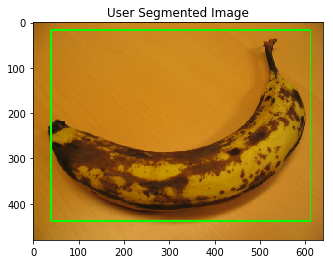

computing epoch  0
computing epoch  1
computing epoch  2


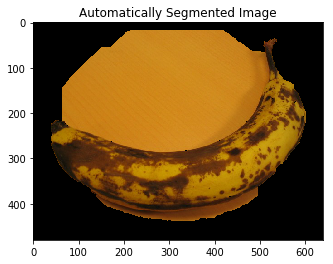

In [7]:
filename = './samples/banana1.jpg'
T, alphas, output = None, None, None
try:
    T, alphas, output = run(filename)
    plt.title('Automatically Segmented Image')
    plt.imshow(output[:,:,[2,1,0]])
    plt.show()
finally:
    cv2.destroyAllWindows()

# Part 3: User Editing

The user can mark certain pixels to be background (left mouse click) or foreground (right mouse click). This updates the $\alpha$ values of the pixels, as well as updates the trimap $T$

In [8]:
class EventHandler2:
    def __init__(self, img, T, alphas):    
        self.draw = False
        self.T = T
        self.alphas = alphas
        self.img = img
        self.ldrawing = False
        self.rdrawing = False
    
    def handler(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.ldrawing = True
            cv2.circle(self.img,(x,y),3,(0,0,0),-1)
            cv2.circle(self.alphas,(x,y),3,0,-1)
            cv2.circle(self.T,(x,y),3,1,-1)
        elif event == cv2.EVENT_MOUSEMOVE:
            if self.ldrawing == True:
                cv2.circle(self.img,(x,y),3,(0,0,0),-1)
                cv2.circle(self.alphas,(x,y),3,0,-1)
                cv2.circle(self.T,(x,y),3,1,-1)
            elif self.rdrawing == True:
                cv2.circle(self.img,(x,y),3,(255,255,255),-1)
                cv2.circle(self.alphas,(x,y),3,1,-1)
                cv2.circle(self.T,(x,y),3,1,-1)
        elif event == cv2.EVENT_LBUTTONUP:
            self.ldrawing = False
            cv2.circle(self.img,(x,y),3,(0,0,0),-1)
            cv2.circle(self.alphas,(x,y),3,0,-1)
            cv2.circle(self.T,(x,y),3,1,-1)
        elif event == cv2.EVENT_RBUTTONDOWN:
            self.rdrawing = True
            cv2.circle(self.img,(x,y),3,(255,255,255),-1)
            cv2.circle(self.alphas,(x,y),3,1,-1)
            cv2.circle(self.T,(x,y),3,1,-1)
        elif event == cv2.EVENT_RBUTTONUP:
            self.rdrawing = False
            cv2.circle(self.img,(x,y),3,(255,255,255),-1)
            cv2.circle(self.alphas,(x,y),3,1,-1)
            cv2.circle(self.T,(x,y),3,1,-1)

In [9]:
def run2(filename, T, alphas, img):
    img2 = img.copy()
    output = np.zeros(img.shape, np.uint8)

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    EventObj = EventHandler2(img, T, alphas)
    cv2.setMouseCallback('Input Image', EventObj.handler)

    while(1):
        img = EventObj.img
        T = EventObj.T
        alphas = EventObj.alphas
        cv2.imshow('Input Image', img)
        
        # key bindings
        k = cv2.waitKey(1)
        if k == 13: # press 'Enter' to begin automatic segmentation
            plt.title('User Segmented Image')
            plt.imshow(img[:,:,[2,1,0]])
            plt.show()
            
            cv2.destroyAllWindows()
            alphas = grabCut(cv2.imread(filename), T, alphas)
            EventObj.alphas = alphas
            break
    mask = np.where((alphas == 1), 255, 0).astype('uint8')
    output = cv2.bitwise_and(img2, img2, mask = mask)
    return T, alphas, output

The following block can be run multiple times. A new window will pop up asking for user interaction. The user can left click on the image to mark the background. Right clicking on the image will mark the foreground. These marks will be used to update the trimpa $T$, and the grab cut algorithm will be run on the image again

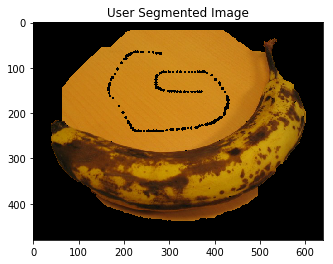

computing epoch  0
computing epoch  1
computing epoch  2


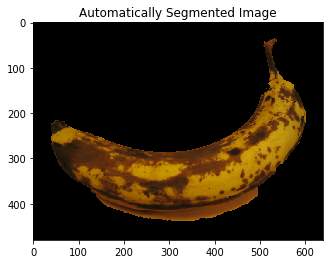

In [11]:
try:
    T, alphas, output = run2(filename, T, alphas, output)
    plt.title('Automatically Segmented Image')
    plt.imshow(output[:,:,[2,1,0]])
    plt.show()
finally:
    cv2.destroyAllWindows()